Getting Satellite and Terrain maps
-----------------------------------------------------------

Go to [Google cloud console](https://console.cloud.google.com/marketplace/details/google/static-maps-backend.googleapis.com?) and activate your static map API.
Store your API key in a file somewhere safe and accessible, we will need it.

In [3]:
import requests

In [4]:
def get_api_key():
    with open('/home/gokul/.api_keys/static_gmaps.key') as rfile:
        return rfile.readline()[:-1]

In [5]:
api_key = get_api_key()

Check out [Google Maps API Reference](https://developers.google.com/maps/documentation/maps-static/dev-guide)

Further Styling required for better mapping [GMaps styling](https://developers.google.com/maps/documentation/maps-static/styling)

[color](https://www.schemecolor.com/microsoft-grapes-emoji-colors.php)  

[styling](https://mapstyle.withgoogle.com/)

In [13]:
def get_static_map(lat=40.714738, long=-73.998693, zoom=12,
                   size=512, maptype='roadmap', labels=False):
    
    url = "https://maps.google.com/maps/api/staticmap?"
    # url += "sensor=false&"
    url += f"size={size}x{size + 25}&"
    url += f"center={lat},{long}&"
    url += f"zoom={zoom}&"
    url += f"maptype={maptype}&"
    url += f"format=png&"
    if maptype == 'roadmap':
        url += "style=color:0x000000|visibility:simplified&"
        url += "style=feature:administrative.land_parcel|visibility:off&"
        url += "style=feature:road|color:0xff0000|visibility:simplified&"
    if not labels:
        url += "style=feature:all|element:labels|visibility:off&"
    url += f"key={api_key}"
    data = requests.get(url)
    return data.content

In [14]:
def save_image(data, fname):
    with open(fname, 'wb') as wfile:
        wfile.write(data)

In [15]:
import cv2
import numpy as np

def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")

In [17]:
plt.rcParams['figure.figsize'] = [8.0, 8.0]

In [18]:
img_data = get_static_map(maptype='roadmap', zoom=16)

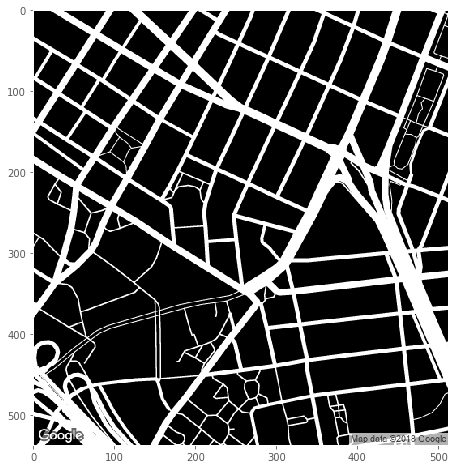

In [19]:
im = cv2.imdecode(np.frombuffer(img_data, np.uint8), cv2.IMREAD_COLOR)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.grid(False)

Let's get some idea which zoom level and maptype will be suitable for our purpose

In [25]:
for m in ['terrain', 'satellite', 'roadmap', 'hybrid']:
    for z in range(12, 19):
        save_image(get_static_map(zoom=z, maptype=m),
                   'checking/' + str(z) + '/' + m + str(z) + '.png')

Looking manually through map images all the zoom levels generated above, I choose to work with zoom level 16

Input Map [satellite]
----------------

<img src="images/satellite16.png" alt="Drawing" style="width: 300px;"/>


Output Map [modified roadmap]
----------------

<img src="images/roadmap16.png" alt="Drawing" style="width: 300px;"/>

Let's check at this zoom level, what is scale of the map we got.

Using Google maps distance measurement tool, the aproximate length cover my the above map is `~ 930 m (3050 ft)`

<img src="images/distance.png" alt="Drawing" style="width: 300px;"/>

Let's suppose we choose a city ex. *San Francisco*, then we could get enough map data by calling the above function n-times with randomly choosen lat-longs inside the city. To make sure that no 2 maps images overlap the same area/land, we need to make sure that the choosen lat-longs are atleast `930 m` away (let's say `1000 m` away for saftey). 

**\# bounding boxes of city**

If we know the bounding boxed of a city, we can divide the whole city into `1000 m` by `1000 m` grids, we could either use all the lat-longs from grid or randomly select some to get the required maps.

**We can randomly generate lat-longs, but how do we know it is inside the city or even worse not in the ocean ?**

I found Geographical boundaries of Bay Area [here](https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-Counties/s9wg-vcph)

<img src="images/counties.png" alt="Drawing" style="width: 300px;"/>

In [11]:
import shapefile
import numpy as np

In [12]:
sf = shapefile.Reader('SanFrancisco/BayAreaCounties.shp')

In [13]:
len(sf.shapes())

9

This shape file contains 9 Counties

**Bounding box for Napa**

In [14]:
county_np = sf.shape(3)

Bounding Box for Napa county

In [15]:
x_lon = np.array([point[0] for point in county_np.points])
y_lat = np.array([point[1] for point in county_np.points])

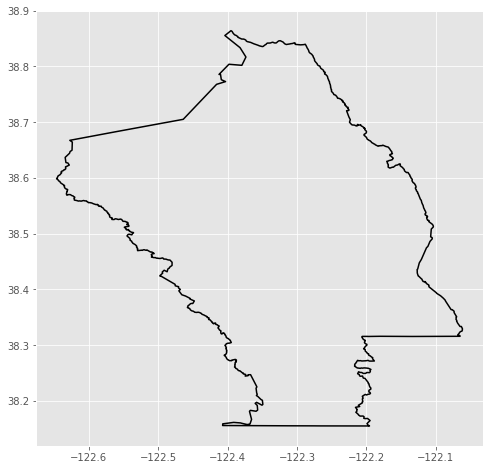

In [16]:
plt.plot(x_lon, y_lat,'k')

In [17]:
county_np.bbox

[-122.64642100248683, 38.15489399914849, -122.06137900148687, 38.864244998709104]

**Bounding box for San Franciso after removing islands**

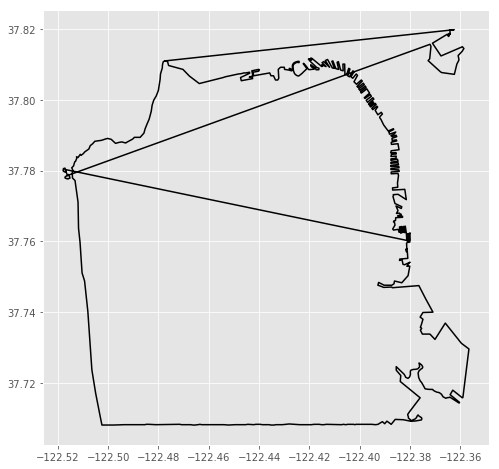

In [18]:
county_sf = sf.shape(4)
x_lon = np.array([point[0] for point in county_sf.points])
y_lat = np.array([point[1] for point in county_sf.points])

# removing the islands
check1 = x_lon >= -122.6
check2 = y_lat <= 37.82
check3 = x_lon <= -122.35
check = check1 & check2 & check3

plt.plot(x_lon[check], y_lat[check],'k')

In [19]:
print(x_lon[check].min(), x_lon[check].max())
print(y_lat[check].min(), y_lat[check].max())

-122.51791400173342 -122.35658100345557
37.708131998193814 37.81984899983388


I choose **Napa** and **San Francisco** counties as one will be city other will be urban

**Creating a `1000 m` x `1000 m` Grid**

Since Earth is sperical the actual disctance between 2 points is not the eucledian distance but the distance across the great-circle joining the 2 points. To do this we need to use somthing called [HaverSine](https://en.wikipedia.org/wiki/Haversine_formula) formulae. 

Ideally we would be implementing [this algorithm](http://www.edwilliams.org/avform.htm#LL) to find a lat-long that is some distance away from the reference at some angle with respect to due north. But since our distance is small we don't have to go through the this hasle. There is this quick and dirty trick mentioned [here](https://gis.stackexchange.com/questions/2951/algorithm-for-offsetting-a-latitude-longitude-by-some-amount-of-meters?rq=1).

In [20]:
import math

In [21]:
def project_lat_long(lat, long, theta, dist):
    
    '''
    function to get new lat-long which is far away from the 
    given lat-long by `dist` [meters] at an `theta` [degrees]
    from the north measured in clockwise direction.
    '''
    theta = math.radians(theta)
    
    m_per_lat = 111_111 
    m_per_long = 111_111 * math.cos(lat)
    
    return (lat + math.cos(theta) * (dist / m_per_lat),
            long + math.sin(theta) * (dist / m_per_long))

In [22]:
def make_grids(lat_min, lat_max, long_max, long_min, spacing=1000):
    grids = []
    y = lat_min
    x = long_min
    while x < long_max:
        while y < lat_max:
            grids += [(y, x)]
            y, x = project_lat_long(lat=y, long=x, theta=0, dist=1000)
        y = lat_min
        y, x = project_lat_long(lat=y, long=x, theta=90, dist=1000)
    return grids

** Making grids **

In [23]:
grids_sf = np.array(make_grids(lat_min=37.708131, lat_max=37.8198489,
                               long_min=-122.517914, long_max=-122.356581,
                               spacing=1000))

grids_np = np.array(make_grids(lat_min=38.154893, lat_max=38.864244,
                               long_min=-122.646421, long_max=-122.061379,
                               spacing=1000))

In [24]:
print(f"No of points in SF: {grids_sf.shape}")
print(f"No of points in Napa: {grids_np.shape}")

No of points in SF: (234, 2)
No of points in Napa: (4661, 2)


** let's remove the points not inside the San Francisco boundary **

In [25]:
from shapely.geometry import Polygon, Point

In [26]:
polygon_sf = Polygon(county_sf.points)
polygon_np = Polygon(county_np.points)

In [27]:
grids_sf_in = [p if Point(p[1], p[0]).within(polygon_sf) else None for p in grids_sf]
grids_sf_in = np.array(list(filter(None.__ne__, grids_sf_in)))

grids_np_in = [p if Point(p[1], p[0]).within(polygon_np) else None for p in grids_np]
grids_np_in = np.array(list(filter(None.__ne__, grids_np_in)))

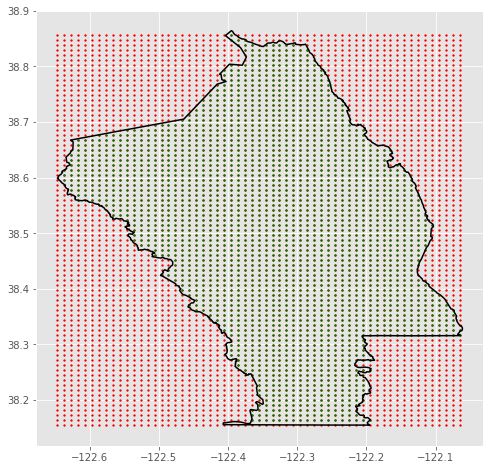

In [28]:
x_lon = np.array([point[0] for point in county_np.points])
y_lat = np.array([point[1] for point in county_np.points])

plt.plot(x_lon, y_lat,'k')
plt.scatter(grids_np[:, 1], grids_np[:, 0], c='r', s=3)
plt.scatter(grids_np_in[:, 1], grids_np_in[:, 0], c='g', s=3)

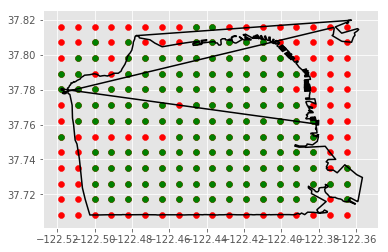

In [25]:
x_lon = np.array([point[0] for point in county_sf.points])
y_lat = np.array([point[1] for point in county_sf.points])

# removing the islands
check1 = x_lon >= -122.6
check2 = y_lat <= 37.82
check3 = x_lon <= -122.35
check = check1 & check2 & check3

plt.plot(x_lon[check], y_lat[check],'k')
plt.scatter(grids_sf[:, 1], grids_sf[:, 0], c='r')
plt.scatter(grids_sf_in[:, 1], grids_sf_in[:, 0], c='g')

In [29]:
# we need to multiply by 2 because one object for input and one for output
print(f"Total objects: {(grids_np_in.shape[0] + grids_sf_in.shape[0])*2}")

Total objects: 4968


let's save the maps
-------------------------

In [30]:
count = 1
for p in grids_sf_in:
    save_image(get_static_map(zoom=16, maptype='satellite', lat=p[0], long=p[1]), 
                'data/sanfrancisco/sat/' + str(count) + '.png')
    count += 1

count = 1
for p in grids_sf_in:
    save_image(get_static_map(zoom=16, maptype='roadmap', lat=p[0], long=p[1]), 
                'data/sanfrancisco/road/' + str(count) + '.png')
    count += 1

In [31]:
np.random.seed(seed=42)

In [32]:
# just choosing a subzset of 300
idx = np.random.randint(grids_np_in.shape[0], size=300)
grids_np_sub = grids_np_in[idx, :]

count = 1
for p in grids_np_sub:
    save_image(get_static_map(zoom=16, maptype='satellite', lat=p[0], long=p[1]), 
                'data/napa/sat/' + str(count) + '.png')
    count += 1

count = 1
for p in grids_np_sub:
    save_image(get_static_map(zoom=16, maptype='roadmap', lat=p[0], long=p[1]), 
                'data/napa/road/' + str(count) + '.png')
    count += 1

** Removing banner **

If we take a close look the bottom of both the satellite and roadmap images, we can see the google water mark, we need to clean these before using it for modeling.

<img src="images/sat_crop.png" alt="Drawing" style="width: 300px;"/>

<img src="images/ter_crop.png" alt="Drawing" style="width: 300px;"/>

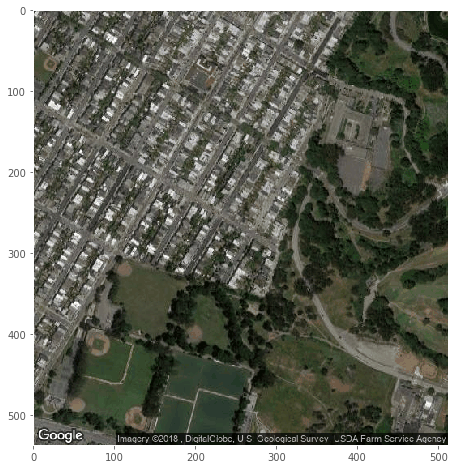

In [33]:
im = read_image('data/sanfrancisco/sat/86.png')
plt.imshow(im)
plt.grid(False)

I have intententionaly increased the length so we could cut the banner off.

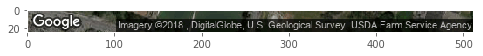

In [34]:
im_crop = im[512:, :]
plt.imshow(im_crop)
plt.grid(False)

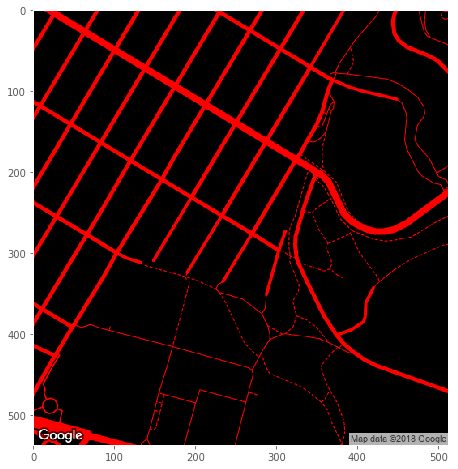

In [35]:
im = read_image('data/sanfrancisco/road/86.png')
plt.imshow(im)
plt.grid(False)

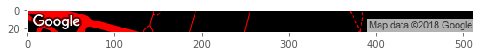

In [36]:
im_crop = im[512:, :]
plt.imshow(im_crop)
plt.grid(False)

Height of 490 seem to be a good cut-off for removing the watermark. We will also make width to be 490 to make it perfect square

In [37]:
def crop_watermark(fpath):
    im = read_image(fpath)
    im_crop = im[:512, :]
    cv2.imwrite(fpath, cv2.cvtColor(im_crop, cv2.COLOR_RGB2BGR))

In [108]:
from pathlib import Path

In [109]:
path = Path('.')

In [45]:
for fpath in list((path/'data/sanfrancisco/sat/').iterdir()):
    crop_watermark(str(fpath))

In [46]:
for fpath in list((path/'data/sanfrancisco/road/').iterdir()):
    crop_watermark(str(fpath))

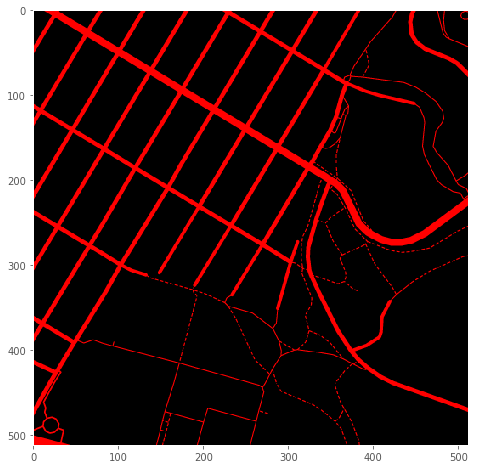

In [47]:
im = read_image('data/sanfrancisco/road/86.png')
plt.imshow(im)
plt.grid(False)

The water-mark is now removed.

In [48]:
for fpath in list((path/'data/napa/sat/').iterdir()):
    crop_watermark(str(fpath))
    
for fpath in list((path/'data/napa/road/').iterdir()):
    crop_watermark(str(fpath))

Maps Static API Static Maps: `1240` costs `$2.48` @ 0.2 cents per API call.

**Convert from roadmaps .png files to mask label type .png**

In [67]:
from PIL import Image
import numpy as np

In [114]:
def convert_to_mask(fpath, thres=10):
    im = read_image(fpath)
    immsk = 1 * (im > 10)
    immsk = Image.fromarray(immsk[:,:,0].astype(np.uint8))
    immsk.save(fpath)
    return None

In [115]:
for fpath in list((path/'data/napa/road/').iterdir()):
    convert_to_mask(str(fpath))